In [1]:
import numpy as np
import pandas as pd

import torch
from PIL import Image

# GCN for background detection

## Loading Data
---
We'll start by loading our images. We will load three files.
1. The image we are going to remove the background of;
2. The image with red and green points showing examples of background and non-background pixels;
3. The image containing only the sample pixels used as our ground truth.

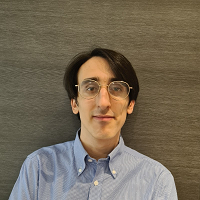

In [2]:
path = "images/200photo24.bmp"
starting_image = Image.open(path)
starting_image

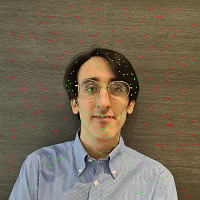

In [3]:
path = "images/200photo24pointed.bmp"
pointed_image = Image.open(path)
pointed_image

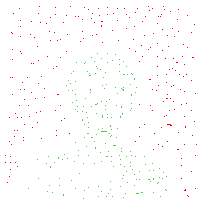

In [4]:
path = "images/200photo24gt.bmp"
gt_image = Image.open(path)
gt_image

Loading the images to show them is helpful to understand the model and the process. For training, however, we need data in tensor form. Moreover, since we are using Graph Convolutional Networks with PyTorch Geometric, we need the data stored as a graph with node features and edges.

We are thus now going to load our data directly in the form we need it, using the functions defined in the data module.

In [5]:
from src import data
from torch_geometric.data import Data

In [6]:
path = "images/200photo24.bmp"
im_graph = data.read_image(path)
im_graph

Data(edge_index=[2, 159199], x=[40000, 3])

Notice that, since we are using a graph, the features are not stored as a 3D array (width, height, channels) as in the usual way, but as a 2D array (pixels, channels) and the pixel geometric information is contained in the edge data.

In [7]:
path = "images/200photo24gt.bmp"
gt, idx = data.read_image_points(path)

Here we loaded our ground truth pixels. The tensor gt contains the actual ground truth (1 for background pixels, 0 for non-background or hidden pixels). Since we loaded the full image, but our ground truth contains only a (small) subset of pixels, we need the idx tensor to mask the unknown from the known ones.

We are also going to split the masking tensor in train and validation mask, as it usual when training neural networks. We are not going to use a test set because working with a single image, we will test the model simply by looking at the result and see if we get a satisfying result.

In [8]:
import random
random.seed(1997)

In [9]:
indexes = torch.nonzero(idx)
aux = list(range(len(indexes)))
random.shuffle(aux)

train_idx = aux[:350]
val_idx = aux[350:]

train_idx = indexes[train_idx]
val_idx = indexes[val_idx]

## Training
---

We are now going to train our model. We are going to use a simple GCN with one hidden layer. During one epoch the full image graph is processed and the training loss is computed for those pixels belonging to our ground truth. We consider training on a single sample a full epoch because, intuitively, our actual samples are the pixels, not the full image.

The validation accuracy is computed at end of every epoch and lastly, the model with the best validation loss is taken.

This is the configuration of the training process (being this a simple task, not much complexity is required):
1. GCN with one hidden layer;
2. Hidden representation dimension of 32;
3. Dropout with p = 0.8 at the hidden layer;
4. Adam optimizer with a learning rate of 1e-2;
5. 500 maximum epochs and early stopping after the validation loss has not improved for 50 epochs.

In [10]:
from src import model

In [11]:
net = model.Net({"depth" : 2, "hidden_dim" : 32, "dropout" : 0.8})
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience = 20)

In [12]:
results = model.train(im_graph, gt, net, train_idx, val_idx, optimizer, scheduler, early_stopping = 50, epochs = 500, verbose = 20)

Epoch 20 finished. Train loss equal to 11.694101333618164.
Validation loss equal to tensor(2.9042).
Validation accuracy equal to 0.6984126984126984.

Epoch 40 finished. Train loss equal to 0.5006157755851746.
Validation loss equal to tensor(0.4432).
Validation accuracy equal to 0.9444444444444444.

Epoch 60 finished. Train loss equal to 0.3222944140434265.
Validation loss equal to tensor(0.2360).
Validation accuracy equal to 0.9603174603174603.

Epoch 80 finished. Train loss equal to 0.19837848842144012.
Validation loss equal to tensor(0.1214).
Validation accuracy equal to 0.9761904761904762.

Epoch 100 finished. Train loss equal to 0.12788702547550201.
Validation loss equal to tensor(0.1060).
Validation accuracy equal to 0.9523809523809523.

Epoch 120 finished. Train loss equal to 0.12310399860143661.
Validation loss equal to tensor(0.0977).
Validation accuracy equal to 0.9761904761904762.

Epoch 140 finished. Train loss equal to 0.08461233973503113.
Validation loss equal to tensor(0.

In [13]:
import seaborn as sns

In [14]:
sns.set(rc={"figure.figsize":(20, 9)}) 

<AxesSubplot:title={'center':'Loss plot over the epochs'}, xlabel='Epochs', ylabel='BCE Loss'>

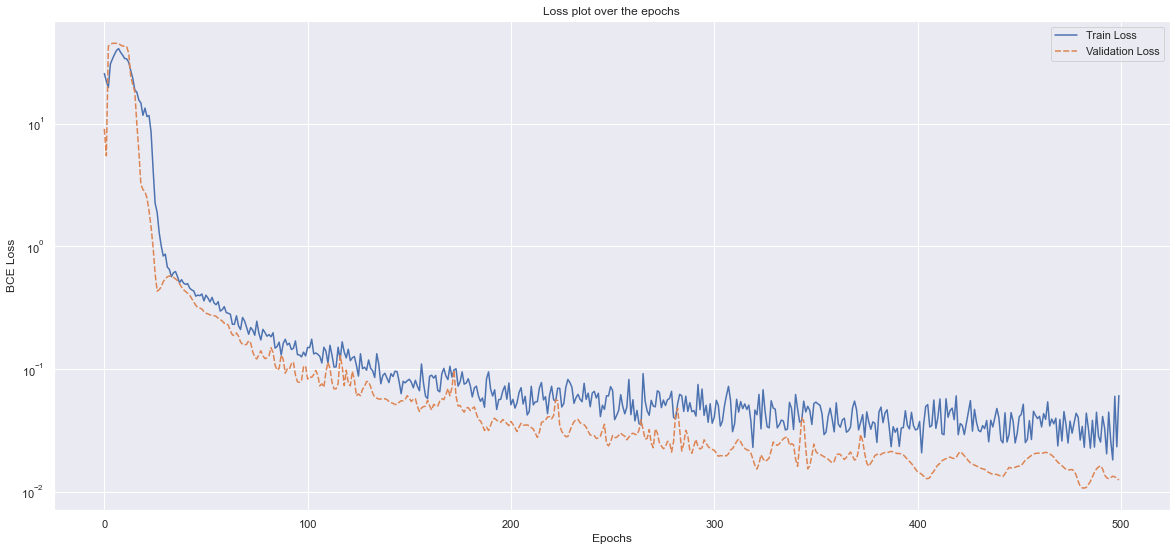

In [15]:
d = pd.DataFrame({"Train Loss" : results["TL"], "Validation Loss" : results["VL"]})
fig = sns.lineplot(data = d)
fig.set(yscale = "log", title = "Loss plot over the epochs", xlabel = "Epochs", ylabel = "BCE Loss")
fig

## Final image
---
Now we are going to use our model to remove the background of the image! Here the step is simple: we use our network on our image and create a new image with a white where our model predicted background pixels and the original image where our model predicted non-background pixels.

In [16]:
net.eval()

Net(
  (conv_start): GCNConv(3, 32)
  (mid_conv): ModuleList(
    (0): GCNConv(32, 32)
  )
  (conv_end): GCNConv(32, 1)
  (act): ReLU()
  (drop): Dropout(p=0.8, inplace=False)
)

In [17]:
starting_tensor = torch.tensor(np.array(starting_image)).type(torch.int)
array = torch.where(net(im_graph) > 0.5, 1, 0).view((200, 200, 1)).repeat((1, 1, 3)) * 255

final_image = torch.where(array == 0, starting_tensor, array.type(torch.int)).numpy()

In [18]:
image = Image.fromarray(np.uint8(final_image))
image.show()
image.save("finalphoto.jpg")

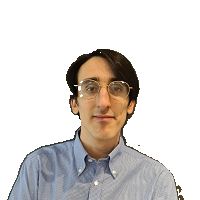

In [19]:
image

And that's all! The result of course isn't perfect and there's room for improvement. But as a simple demonstration, it is good enough!